# **Deep Learning -  Homework - III. Milestone**
---

Group Members: El-Ali Maya (BHI5LF), Simkó Máté (O3BMRX)

###**Chosen task: Friend recommendation with graph neural networks**
###**Dataset: [Facebook Dataset](https://snap.stanford.edu/data/ego-Facebook.html)**


Before running this notebook please upload the models.zip file from the [repo](https://github.com/smkmate/deeplearning-hf)!

# Imports

In [1]:
# install dgl
! pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html
! pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html
! pip install torchmetrics

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 MB 11.2 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.6/111.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.7/96.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 39.2 MB/s

In [2]:
import os
import zipfile, csv, json

import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve


import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy

import networkx as nx
import dgl
from dgl.nn import GraphConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Data

In [4]:
# download the dataset
! wget "https://snap.stanford.edu/data/facebook.tar.gz"
! wget "https://snap.stanford.edu/data/facebook_combined.txt.gz"

--2023-12-10 22:14:27--  https://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K   675KB/s    in 1.1s    

2023-12-10 22:14:29 (675 KB/s) - ‘facebook.tar.gz’ saved [732104/732104]

--2023-12-10 22:14:29--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   381KB/s    in 0.6s    

2023-12-10 22:14:30 (381 KB/s) - ‘facebook_combined.txt.gz’ saved 

In [5]:
# unpack the dataset
! mkdir "data"
! tar -xzf facebook.tar.gz -C /content/data
! gunzip -c facebook_combined.txt.gz > /content/data/facebook_combined.txt

In [6]:
# get the ego users of the subgraphs
folder_path = "/content/data/facebook"
ego_users = []

for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        # Split the filename and extension
        name, _ = os.path.splitext(filename)
        ego_users.append(int(name))

ego_users = list(set(ego_users))

print(ego_users)

[0, 107, 3980, 3437, 686, 1684, 1912, 698, 348, 414]


## Utility functions

In [7]:
# function for mapping node labels to node indeces,
# because in most graph the labels don't start at 0 and aren't continuous
def get_index_dicts(node_labels):
  node_labels = sorted(node_labels)

  index_to_label = {}
  label_to_index = {}
  for idx, node_label in enumerate(node_labels):
      index_to_label[idx] = node_label
      label_to_index[node_label] = idx
  return index_to_label, label_to_index

In [8]:
# creates a DGL graph object for each subgraph
def get_dgl_graph(user_id, ego_users):
  # check the id
  if user_id not in ego_users:
    raise Exception("Subgraph not available for user {}".format(user_id))

  # load the data files
  edge_data_file = "/content/data/facebook/{}.edges".format(user_id)
  feat_data_file = "/content/data/facebook/{}.feat".format(user_id)

  # feature data
  feats = []
  node_labels = []
  with open(feat_data_file) as f:  # load node features file
      for line in f:
          node_labels.append(int(line.split()[0])) # first element in row is the node label
          a = [int(x) for x in line.split()[1:]]  # the others are one-hot encoded categorical labels
          feats.append(torch.tensor(a, dtype=torch.float))
  feats = torch.stack(feats) # concat the features to a single tensor

  # mapping node_labels to indeces
  idx_to_lab_dict, lab_to_idx_dict = get_index_dicts(node_labels)

  # edge data
  edges_u, edges_v = [], []
  with open(edge_data_file) as f:  # load edges file
      for line in f:
          edges_u.append(int(line.split()[0]))
          edges_v.append(int(line.split()[1]))

  # transform node_labels to indeces
  edges_u = [lab_to_idx_dict[x] for x in edges_u]
  edges_v = [lab_to_idx_dict[x] for x in edges_v]
  edges_u, edges_v = np.array(edges_u), np.array(edges_v)

  # Construct graph
  G = dgl.DGLGraph()
  G.add_nodes(len(node_labels)) # nodes
  G.add_edges(edges_u, edges_v) # edges
  G.ndata['feat'] = feats # feature data
  G.ndata['ego_user'] = torch.full((G.ndata['feat'].shape[0],1), user_id) # the ego user who is connected to all nodes in the graph
  G.ndata['node_label'] = torch.tensor(list(idx_to_lab_dict.values()), dtype=torch.int) # the node labels

  return G

## Ego Subgraphs

In [9]:
# read in the ego subgraphs
ego_graphs = []
for user_id in ego_users:
  g = get_dgl_graph(user_id, ego_users)
  ego_graphs.append(g)
ego_graphs

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


[Graph(num_nodes=347, num_edges=5038,
       ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=1045, num_edges=53498,
       ndata_schemes={'feat': Scheme(shape=(576,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=59, num_edges=292,
       ndata_schemes={'feat': Scheme(shape=(42,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=547, num_edges=9626,
       ndata_schemes={'feat': Scheme(shape=(262,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
       edata_schemes={}),
 Graph(num_nodes=170, num_edges=3312,
       

# Data Preparation

We create an inverse of the graphs: G(V,E) is the original graph, invG(V, invE) is the inverse graph. Both graphs have the same nodes and in invG there is a edge between two nodes precisely when there isn't one in G.

This will be used to evaluate whether the model correctly predicts the missing edges as well.

In [10]:
def inverse_edges(G):
  u, v = G.edges()

  # Find all negative edges
  adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy()))) # sparse adjencency matrix
  adj_neg = 1 - adj.todense() - np.eye(G.number_of_nodes())  # substract the og adjacency matrix and the self loops from the identity matrix
  neg_u, neg_v = np.where(adj_neg != 0)

  return neg_u, neg_v

Usually for a friend recommendation system for the train/test split we split the data in time: the train set would be the edges at a given time, and the test set would be the edges at a later time. However this is not available for this dataset, so we split the edges randomly into 3 sets: training, validation and test

In [11]:
def split_graph(g, TEST_RATIO = 0.2, VAL_RATIO = 0.1):
  # for recreatability
  np.random.seed(42)

  # edges
  u, v = g.edges()

  # edge ids
  eids = np.arange(g.number_of_edges())
  eids = np.random.permutation(eids) # random permutation, for randomness in split
  test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set
  val_size = int(len(eids) * VAL_RATIO)   # number of edges in val set
  train_size = g.number_of_edges() - test_size - val_size # number of edges in train set

  # get positive edges for test and train -> split the edge data
  test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
  val_pos_u, val_pos_v = u[eids[test_size:test_size + val_size]], v[eids[test_size:test_size + val_size]]
  train_pos_u, train_pos_v = u[eids[test_size + val_size:]], v[eids[test_size + val_size:]]

  # Find all negative edges
  neg_u, neg_v = inverse_edges(g)

  # split the negative edges
  neg_eids =  np.random.choice(len(neg_u), g.number_of_edges()) # get the same number of negative edges
  # split the data
  test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
  val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size + val_size]], neg_v[neg_eids[test_size:test_size + val_size]]
  train_neg_u, train_neg_v = neg_u[neg_eids[test_size + val_size:]], neg_v[neg_eids[test_size + val_size:]]

  # construct positive and negative graphs
  train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
  train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

  val_pos_g = dgl.graph((val_pos_u, val_pos_v), num_nodes=g.number_of_nodes())
  val_neg_g = dgl.graph((val_neg_u, val_neg_v), num_nodes=g.number_of_nodes())

  test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
  test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

  # training graph
  train_g = dgl.remove_edges(g, eids[:test_size + val_size])
  train_g = dgl.add_self_loop(train_g)

  return {
      'graph': train_g,
      'train_graph': (train_pos_g, train_neg_g),
      'val_graph': (val_pos_g, val_neg_g),
      'test_graph': (test_pos_g, test_neg_g)
      }

In [12]:
split_ego_graphs = []
for g in ego_graphs:
  split_ego_graphs.append(split_graph(g))

In [13]:
split_ego_graphs

[{'graph': Graph(num_nodes=347, num_edges=3875,
        ndata_schemes={'feat': Scheme(shape=(224,), dtype=torch.float32), 'ego_user': Scheme(shape=(1,), dtype=torch.int64), 'node_label': Scheme(shape=(), dtype=torch.int32)}
        edata_schemes={}),
  'train_graph': (Graph(num_nodes=347, num_edges=3528,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=3528,
         ndata_schemes={}
         edata_schemes={})),
  'val_graph': (Graph(num_nodes=347, num_edges=503,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=503,
         ndata_schemes={}
         edata_schemes={})),
  'test_graph': (Graph(num_nodes=347, num_edges=1007,
         ndata_schemes={}
         edata_schemes={}),
   Graph(num_nodes=347, num_edges=1007,
         ndata_schemes={}
         edata_schemes={}))},
 {'graph': Graph(num_nodes=1045, num_edges=38495,
        ndata_schemes={'feat': Scheme(shape=(576,), dtype=torch.float32), 'ego_user': Schem

# Model definition

We firstly compute the node embeddings using a GCN, and then we predict whether an edge exists by taking the dot product of its nodes and applying that score to the edges.

In [14]:
# build an ordinary GCN model
class GCN(nn.Module):
  def __init__(self, g, in_feats, n_hidden, n_layers, bottleneck = False, activation = F.relu, dropout = 0):
    super(GCN, self).__init__()
    self.g = g
    self.layers = nn.ModuleList()
    # input layer
    self.layers.append(GraphConv(in_feats, n_hidden, activation=activation))
    # hidden layers
    if bottleneck:
      width = n_hidden
      for i in range(n_layers - 1):
        self.layers.append(GraphConv(width, width//2, activation=activation))
        width = width // 2
      # output layer
      self.layers.append(GraphConv(width, width))
    else:
      for i in range(n_layers - 1):
        self.layers.append(GraphConv(n_hidden, n_hidden, activation=activation))
      # output layer
      self.layers.append(GraphConv(n_hidden, n_hidden))
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, features):
    # the H matrix is the feature matrix
    h = features
    # the matrix passes through each layer
    for i, layer in enumerate(self.layers):
      if i != 0:
        h = self.dropout(h)       #dropout
      h = layer(self.g, h)
    return h

In [15]:
# edge predictors
# simple dot predictor
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(dgl.function.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

# Load the models

In [17]:
# function for loading a saved model
def load_model(ego_user):
  # check the id
  if ego_user not in ego_users:
    raise Exception("{} is not an ego user.".format(ego_user))

  # unzip models folder if it hasn't been yet
  if not os.path.exists('models'):
      os.makedirs('models')
      # unzip the file
      with zipfile.ZipFile('models.zip', 'r') as zip_ref:
          zip_ref.extractall('models')

  # load the hyperparameters
  params = {}
  with open(f'models/models/{ego_user}/params.csv', 'r', newline='') as file:
      csv_reader = csv.reader(file)

      # first row contains keys, the second contains values
      keys = next(csv_reader)
      values = next(csv_reader)

      # Create a dictionary from keys and values
      params = dict(zip(keys, values))

  # get the graph
  split_graph = split_ego_graphs[ego_users.index(ego_user)]

  # create model instance with hyperparameters
  model = GCN(g = split_graph['graph'],
              in_feats = split_graph['graph'].ndata['feat'].shape[1],
              n_layers= int(params['n_layers']), n_hidden = int(params['n_hidden']),
              bottleneck = bool(params['bottleneck']), dropout = float(params['dropout']))

  # load the model
  model = torch.load(f"models/models/{ego_user}/best.pt")

  return model

In [18]:
# load the models
models = []

for ego_user in ego_users:
  model = load_model(ego_user)
  models.append(model)

# Friend prediction

The model provides node embeddings, which can be used to calculate edge data. For a given user the dot product of its embedding is calculated with all other users' embeddings, the best ones are chosen.

In [19]:
def friend_rec(ego_user, user_id, num_friends=5):
  # check the ego_user id
  if ego_user not in ego_users:
    raise Exception(f"{ego_user} is not an ego user.")

  # get the ego_graph
  graph = ego_graphs[ego_users.index(ego_user)]

  # check the validity of the user id
  if user_id < 0 or user_id >= graph.number_of_nodes():
    raise Exception(f"Invalid user id: {user_id}, it should be in the range [0,{graph.number_of_nodes()})")

  # get the model
  model = models[ego_users.index(ego_user)] # model = load_model(ego_user)

  # get current friends
  current_friends = []
  n1, n2 = graph.edges()
  for u, v in zip(n1.detach().numpy(), n2.detach().numpy()):
    if u == user_id:
      current_friends.append(v)
    if v == user_id:
      current_friends.append(u)

  current_friends = set(current_friends)

  # create star graph with same amount of nodes as the original, where the center node is the user (user_id)
  G = dgl.DGLGraph()
  G.add_nodes(graph.num_nodes()) # nodes

  #edges
  edges_u = np.full(graph.number_of_nodes()-1, user_id) # array full of userid
  edges_v = np.arange(0, graph.number_of_nodes()) # all nodes
  edges_v = edges_v[edges_v != user_id] # remove self-loop
  G.add_edges(edges_u, edges_v)

  G.ndata['feat'] = graph.ndata['feat']  # feature data
  G.ndata['ego_user'] = graph.ndata['ego_user']  # the ego user
  G.ndata['node_label'] = graph.ndata['node_label'] # the node labels

  # get node embedding
  with torch.no_grad():
    embedding = model(G.ndata['feat'])

  # dot predictor
  pred = DotPredictor()
  # calculate the score of each user
  scores = pred(G, embedding)

  # store the scores with the node labels
  scores = list(zip(edges_v, scores.numpy()))

  # order the scores
  scores.sort(key=lambda x: x[1], reverse = True)

  # get scores for current friends
  current_friend_scores =  [(node, score) for node, score in scores if node in current_friends]
  # get scores for best new suggestions
  new_friends_scores = [(node, score) for node, score in scores if node not in current_friends][:num_friends]

  return current_friend_scores, new_friends_scores, scores

To visualise this we draw the subgraph with the current friends and the newly recommended ones

In [20]:
# calculate positions for the graphs
positions = []
for graph in ego_graphs:
  nxG = dgl.to_networkx(graph)
  pos = nx.kamada_kawai_layout(nxG)
  positions.append(pos)

In [21]:
# draws the whole graph
def visualise_whole_graph(ego_user):
  # get the ego_graph
  graph = ego_graphs[ego_users.index(ego_user)]
  nxG = dgl.to_networkx(graph)
  pos = positions[ego_users.index(ego_user)]

  figsize=(16,16)
  line_style='dotted'

  plt.figure(figsize=figsize)
  plt.axis('off')

  # draw the graph
  nx.draw_networkx(nxG, pos=pos, node_size=100, style=line_style,
                  arrows=False, width=0.5, with_labels=False)

  plt.title(f"The {ego_user} ego graph")
  plt.show()

In [62]:
from re import I
# draws the recommended friends
def visualise_user_graph(ego_user, user_id):
  # get the ego_graph and its data
  graph = ego_graphs[ego_users.index(ego_user)]
  nxG = dgl.to_networkx(graph)
  pos = positions[ego_users.index(ego_user)]

  # predict friends
  curr_friends, new_friends, scores = friend_rec(ego_user, user_id)

  # nodes in subgraph: current friends, recommended friends, and the user
  curr_f = [node for node, _ in curr_friends]
  new_f = [node for node, _ in new_friends]
  nodes_to_include = curr_f + new_f + [user_id]

  # create sub_graph
  sub_graph = nx.Graph(nx.subgraph(nxG, nodes_to_include))
  # add new edges
  new_edges = [(user_id, node) for node in new_f]
  sub_graph.add_edges_from(new_edges)

  # edge visulisation data
  # green for recommended edges
  edge_colors = []
  for u, v in sub_graph.edges:
    # new friends
    if (u in new_f and v == user_id) or (v in new_f and u == user_id):
      edge_colors.append('darkgreen')
    else:
      edge_colors.append('black')

  # positional data
  sub_graph_pos = {}
  for node in nodes_to_include:
    sub_graph_pos[node] = pos[node]

  # figure style
  figsize=(16,16)

  # color the nodes
  color_map = []
  for node in sub_graph:
      if node == user_id:
          color_map.append('lightblue')
      elif node in curr_f:
          color_map.append('yellow')
      elif node in new_f:
          color_map.append('green')

  # draw the graph
  plt.figure(figsize=figsize)
  plt.axis('off')
  nx.draw_networkx(sub_graph, pos=sub_graph_pos, node_size=500, arrows=False,
                   with_labels=True, node_color = color_map, edge_color = edge_colors)
  plt.title(f"The recommendations for user {user_id} in {ego_user} ego graph")
  plt.show()

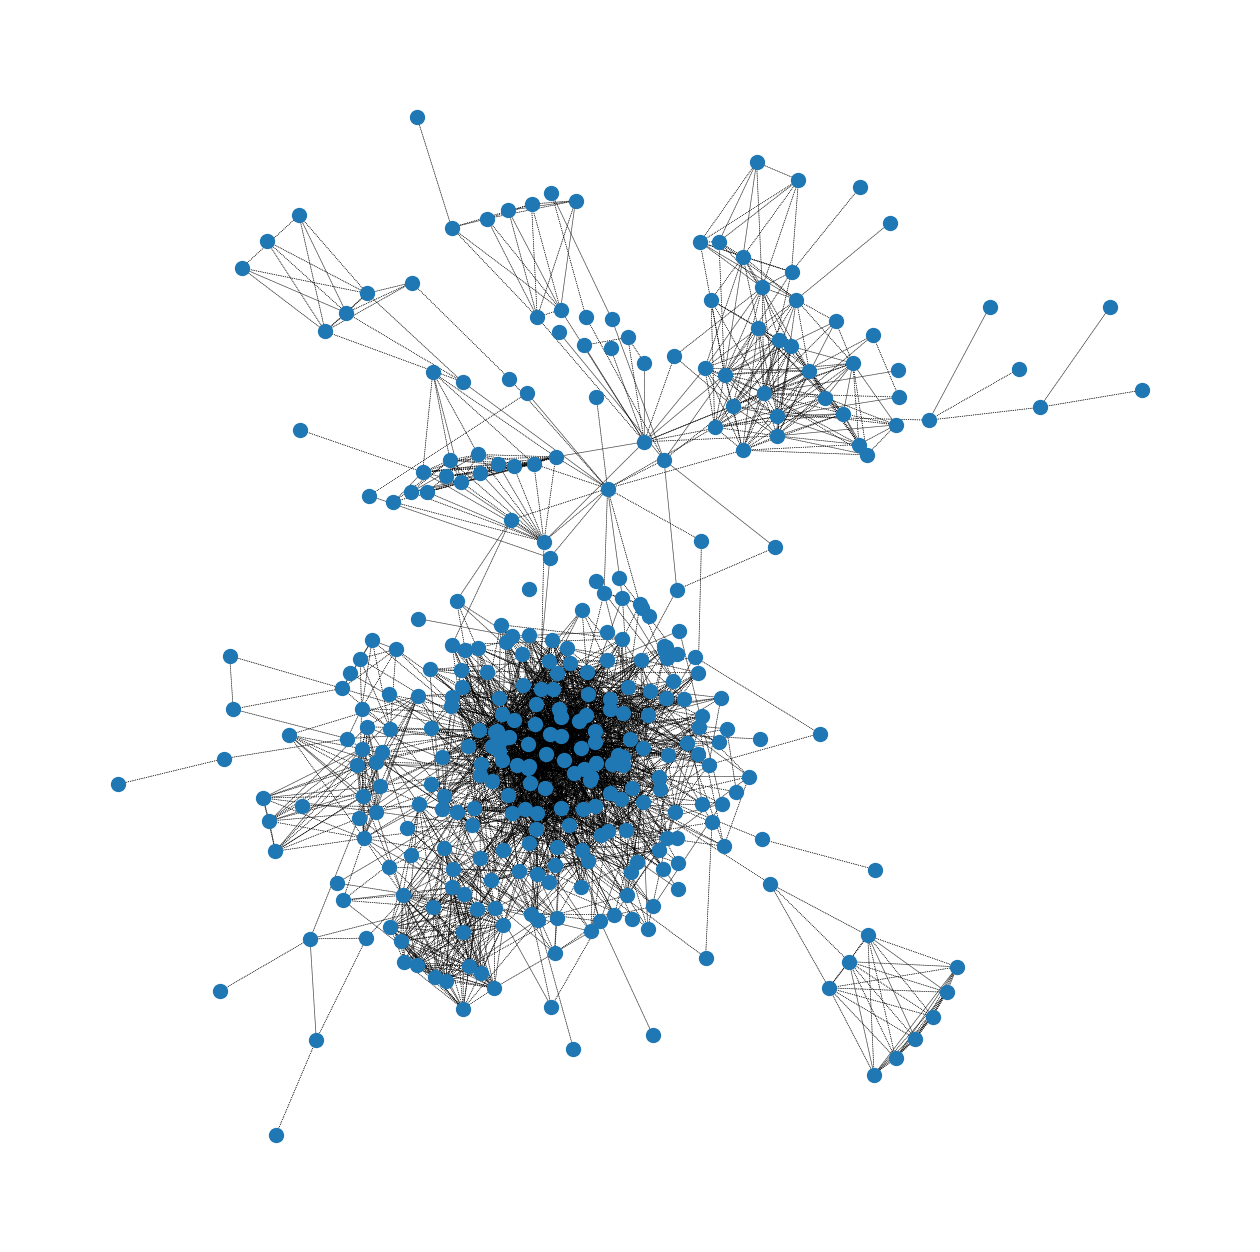

In [53]:
visualise_whole_graph(0)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


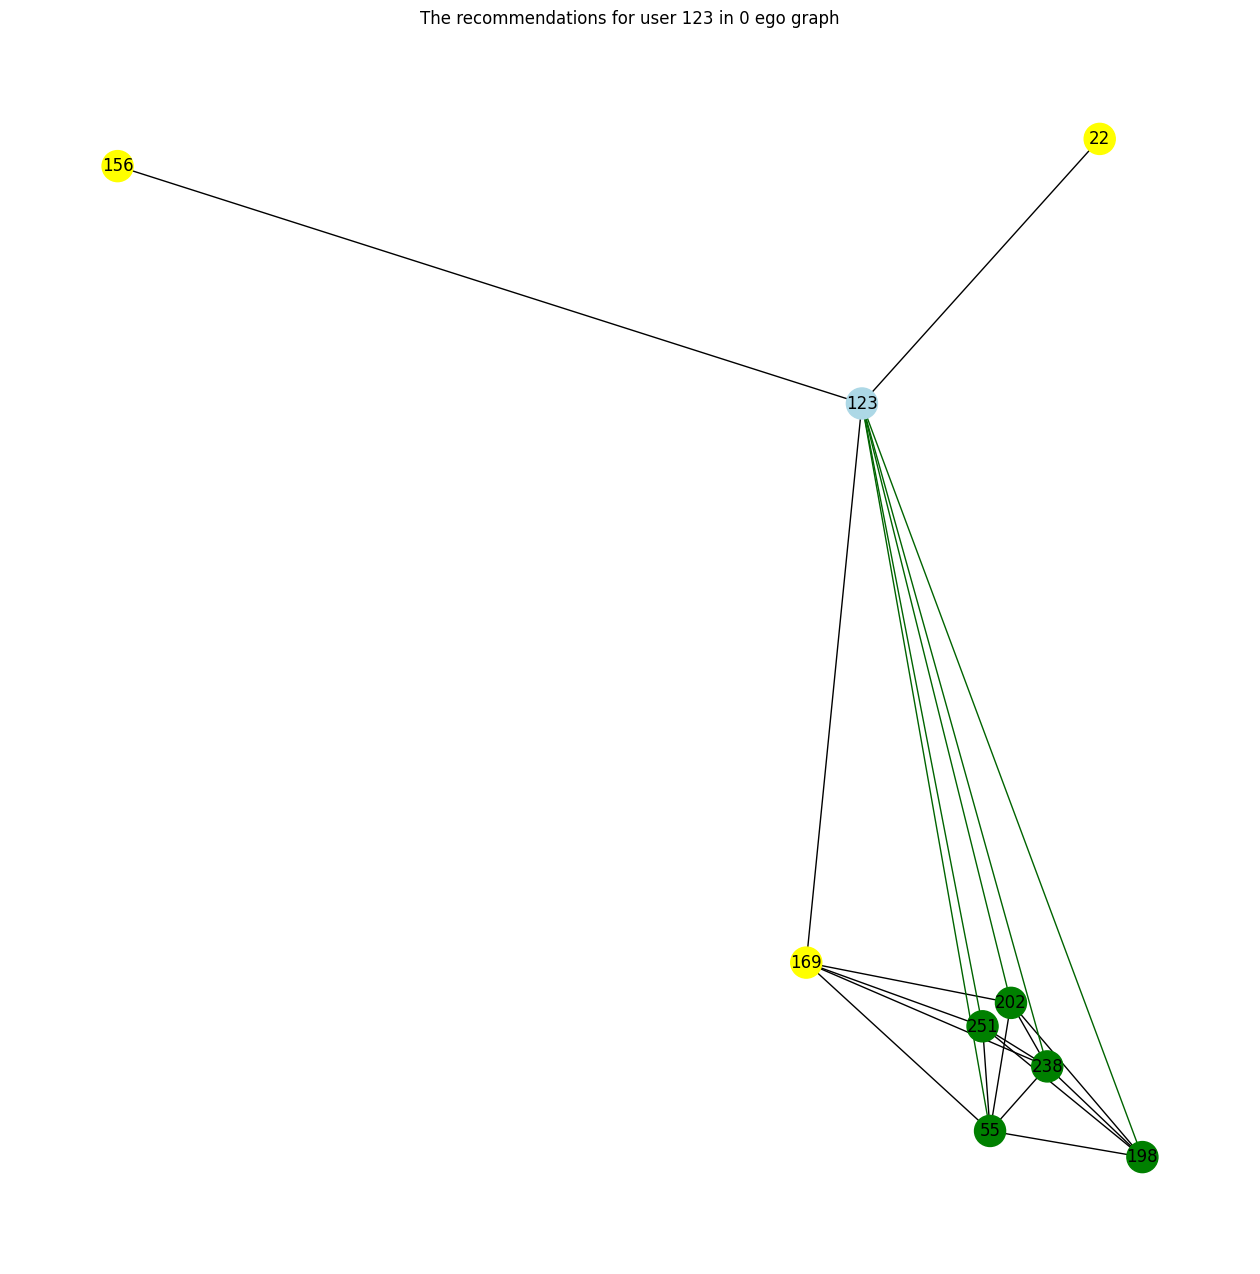

In [63]:
visualise_user_graph(0,123)